# 机器视觉与图像处理 大作业（1）源代码

## Note：本实验为了良好的观感，共有两批运行结果，第一份为轮廓检测样式，第二份为原图检测样式。

### 运行结果的展示每组都是给定的所有六十张图片，其中前20张为良好样本的良好视角，21-30为良好样本不良视角，31-50为缺陷样本的良好视角，51-60为缺陷样本不良视角。识别正确率为100%

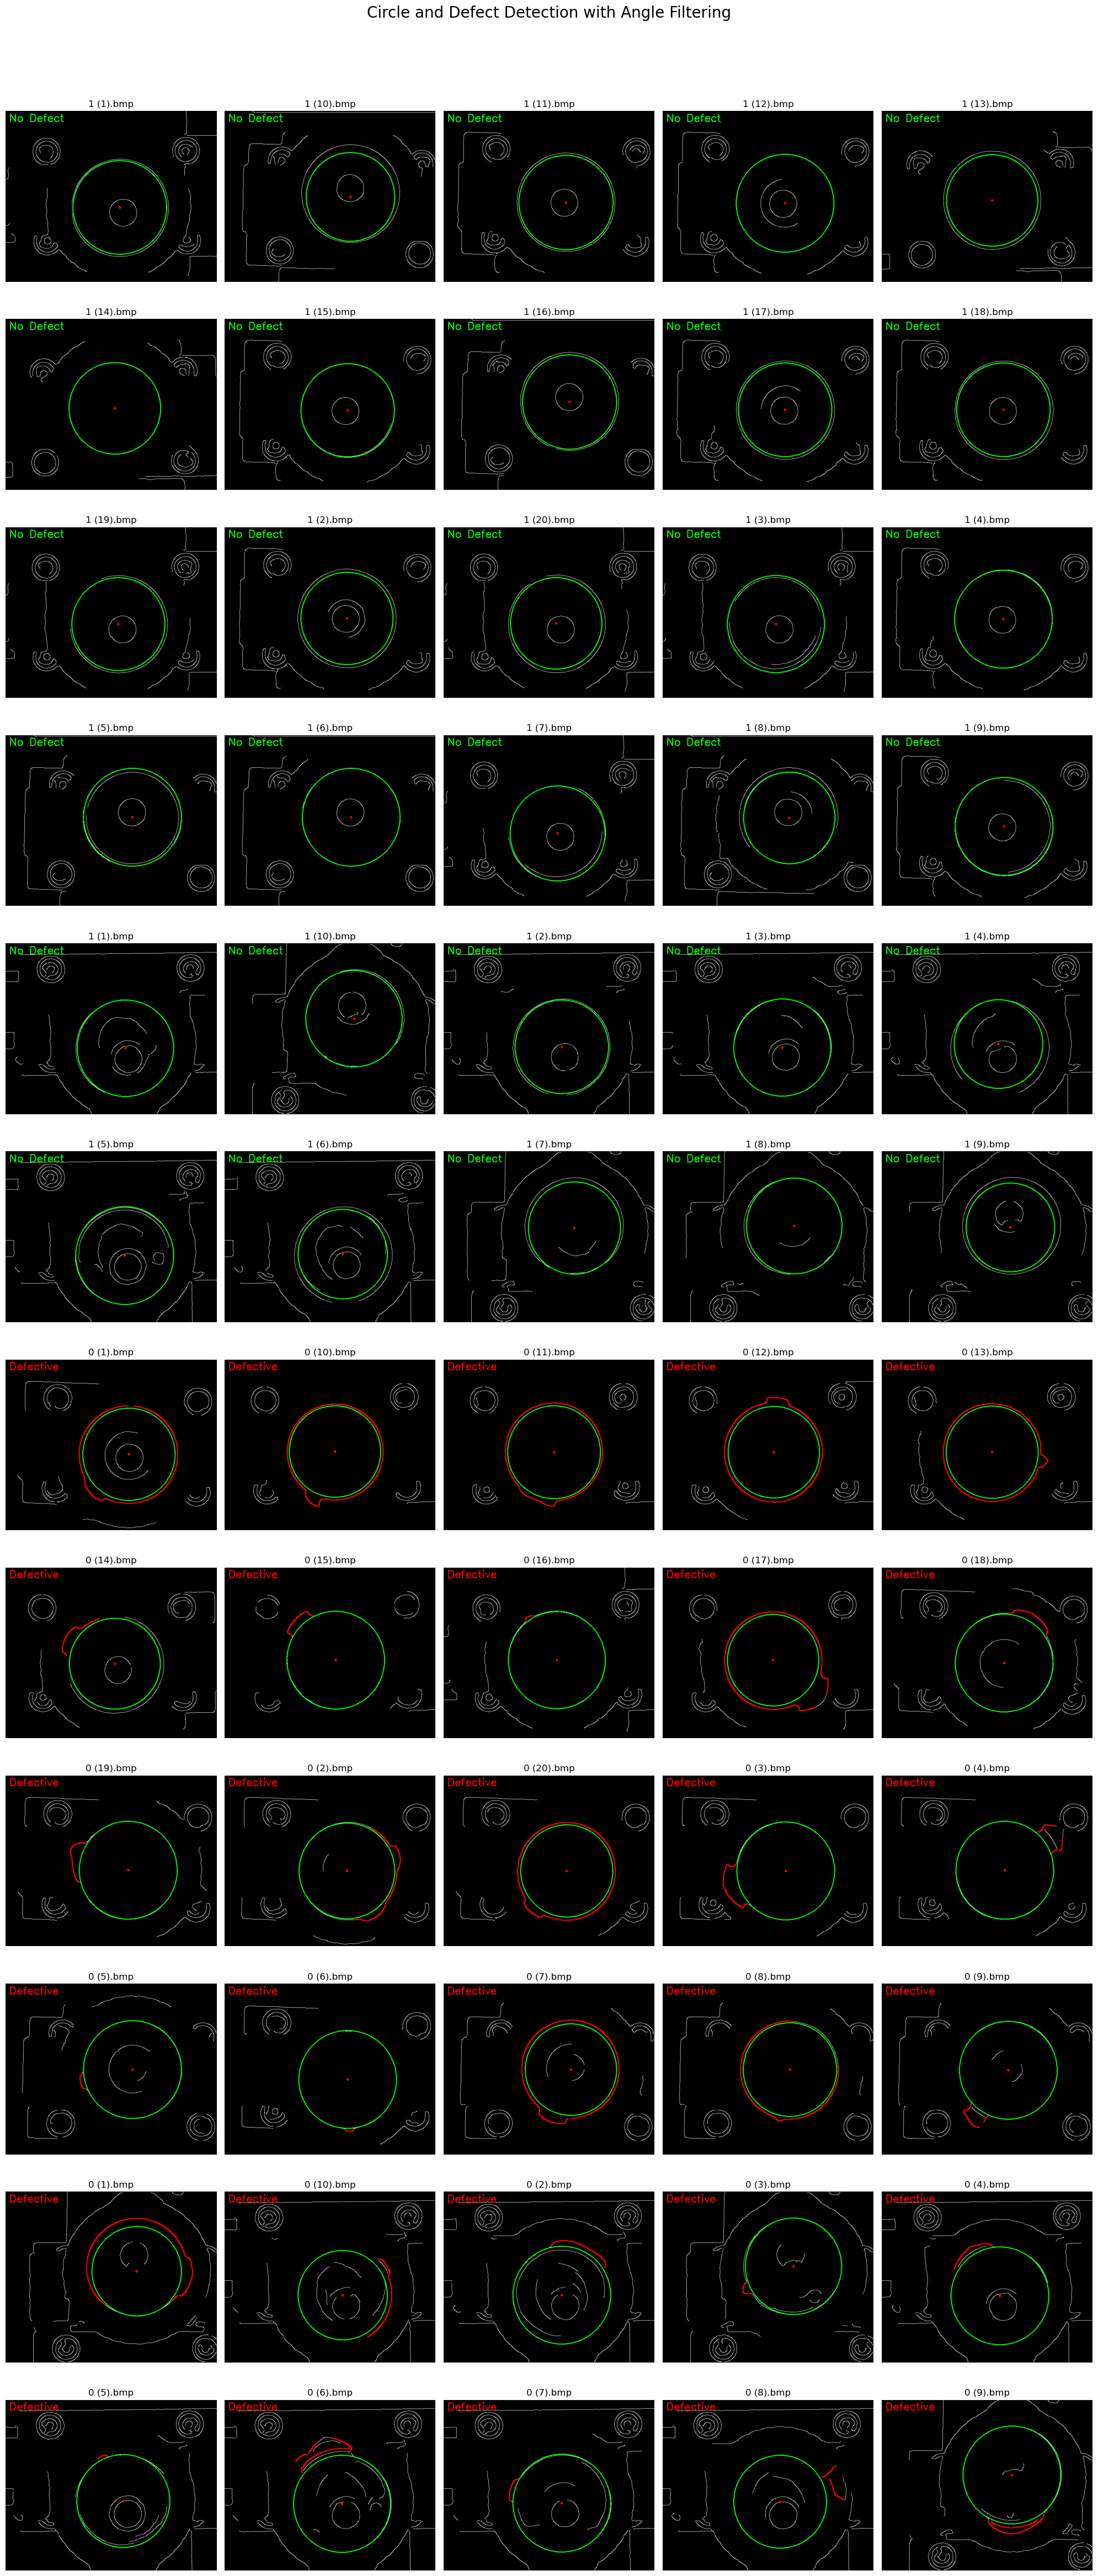

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# 文件夹路径
folders = [
    "./滚轮缺胶样本/良好样本/视角良好/",
    "./滚轮缺胶样本/良好样本/视角不良/",
    "./滚轮缺胶样本/缺陷样本/视角良好/",
    "./滚轮缺胶样本/缺陷样本/视角不良/"
]

# 设置子图网格布局
fig, axes = plt.subplots(12, 5, figsize=(20, 48))  # 12 行 5 列
fig.suptitle("Circle and Defect Detection with Angle Filtering", fontsize=20)

# 固定半径值
fixed_radius = 120

# 图像计数器
image_count = 0

# 遍历每个文件夹
for folder in folders:
    # 获取文件夹中的所有图像文件
    image_files = [f for f in os.listdir(folder) if f.endswith('.bmp')]
    image_files.sort()  # 按文件名排序

    for image_file in image_files:
        if image_count >= 60:  # 确保只显示60张图像
            break
        
        image_path = os.path.join(folder, image_file)
        gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # 检查图像是否加载成功
        if gray_image is None:
            print(f"图像 {image_path} 加载失败，请检查路径是否正确。")
            continue

        # 平滑滤波处理
        smoothed_image = cv2.GaussianBlur(gray_image, (15, 15), 0)  # 高斯滤波，内核大小为15x15

        # Canny 边缘检测
        edges = cv2.Canny(smoothed_image, 100, 200)

        # 使用霍夫圆变换寻找固定半径的圆
        circles = cv2.HoughCircles(
            gray_image,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=30,
            param1=50,  # Canny 边缘检测高阈值
            param2=45,  # 圆检测阈值，值越低检测越敏感
            minRadius=fixed_radius,  # 固定最小半径
            maxRadius=fixed_radius + 20  # 固定最大半径
        )

        # 标注圆形到原始图像
        output_image = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        if circles is not None:
            circles = np.uint16(np.around(circles))

            # 图像中心点坐标
            center_x, center_y = gray_image.shape[1] // 2, gray_image.shape[0] // 2

            # 找到距离中心最近的圆
            min_dist = float("inf")
            best_circle = None
            for i in circles[0, :]:
                dist = np.sqrt((i[0] - center_x) ** 2 + (i[1] - center_y) ** 2)
                if dist < min_dist:
                    min_dist = dist
                    best_circle = i

            # 如果找到了最好的圆
            if best_circle is not None:
                x, y, r = best_circle  # 圆心坐标 (x, y) 和半径 r
                cv2.circle(output_image, (x, y), r, (0, 255, 0), 2)  # 圆的边界
                cv2.circle(output_image, (x, y), 2, (0, 0, 255), 3)  # 圆心

                # 创建掩模，只保留圆的外缘到外缘 2 到 50 像素的区域
                mask = np.zeros_like(edges)
                cv2.circle(mask, (x, y), r + 50, 255, thickness=-1)  # 包括半径外 50 像素
                cv2.circle(mask, (x, y), r + 4, 0, thickness=-1)  # 去除半径外 2 像素内区域

                # 取出掩模范围内的边缘图像
                masked_edges = cv2.bitwise_and(edges, mask)

                # 轮廓检测
                contours, _ = cv2.findContours(masked_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # 过滤和标记缺陷
                has_defect = False
                filtered_contours = []
                for contour in contours:
                    # 计算轮廓点到圆心的距离
                    distances = [np.sqrt((point[0][0] - x) ** 2 + (point[0][1] - y) ** 2) for point in contour]

                    # 计算微分（相邻点之间的距离变化）
                    distance_diff = np.diff(distances)

                    # 判断变化程度是否超过阈值
                    threshold = 2.625  # 根据实际情况调整阈值
                    if np.any(np.abs(distance_diff) > threshold):
                        has_defect = True
                        filtered_contours.append(contour)

                # 重新绘制过滤后的轮廓
                for contour in filtered_contours:
                    cv2.drawContours(output_image, [contour], -1, (0, 0, 255), 2)

                # 标记结果
                # 标记结果
                if has_defect:
                    label = "Defective"
                    color = (0, 0, 255)  # 红色
                else:
                    label = "No Defect"
                    color = (0, 255, 0)  # 绿色

                cv2.putText(output_image, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

        # 在子图中显示结果
        row, col = divmod(image_count, 5)  # 根据 image_count 计算子图的行列位置
        axes[row, col].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        axes[row, col].set_title(f"{image_file}")
        axes[row, col].axis("off")

        image_count += 1

# 调整布局并显示图像
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 为标题留出空间
plt.show()

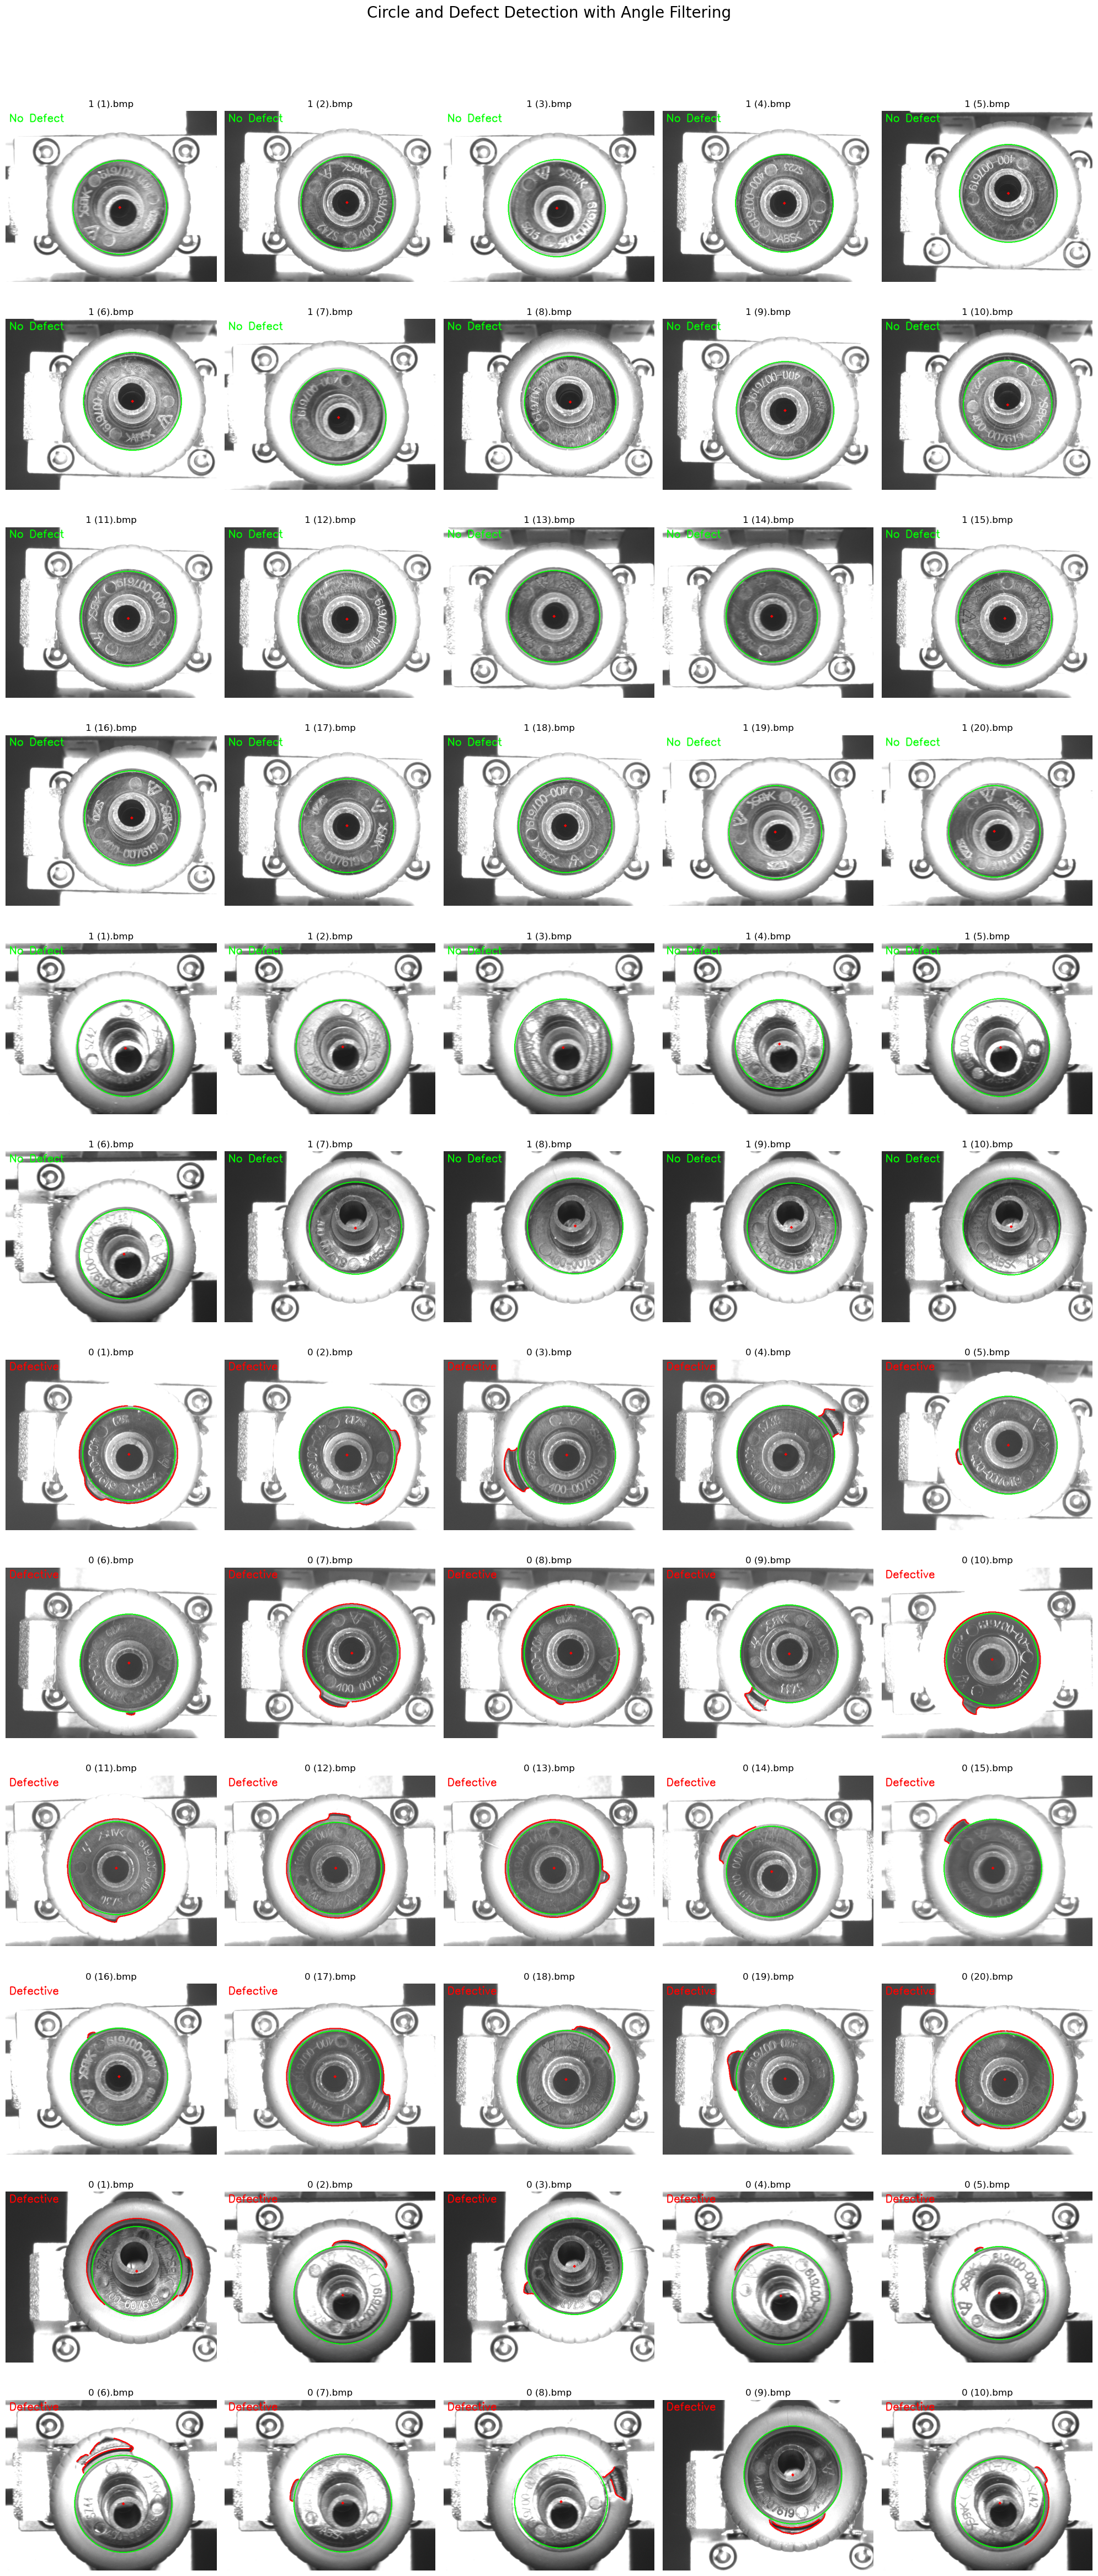

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import re  # 用于自然排序

# 文件夹路径
folders = [
    "./滚轮缺胶样本/良好样本/视角良好/",
    "./滚轮缺胶样本/良好样本/视角不良/",
    "./滚轮缺胶样本/缺陷样本/视角良好/",
    "./滚轮缺胶样本/缺陷样本/视角不良/"
]

# 设置子图网格布局
fig, axes = plt.subplots(12, 5, figsize=(20, 48))  # 12 行 5 列
fig.suptitle("Circle and Defect Detection with Angle Filtering", fontsize=20)

# 设定一个缩放因子
magarg = 1

# 固定半径值
fixed_radius = 120

# 图像计数器
image_count = 0

def natural_key(string):
    """根据自然排序提取排序键，使用字母代替数字进行重新编码"""
    return [chr(int(text) + 65) if text.isdigit() else text for text in re.split(r'(\d+)', string)]

# 遍历每个文件夹
for folder in folders:
    # 获取文件夹中的所有图像文件
    image_files = [f for f in os.listdir(folder) if f.endswith('.bmp')]
    image_files.sort(key=natural_key)  # 使用重新编码后的排序

    for image_file in image_files:
        if image_count >= 60:  # 确保只显示60张图像
            break
        
        image_path = os.path.join(folder, image_file)
        gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # 检查图像是否加载成功
        if gray_image is None:
            print(f"图像 {image_path} 加载失败，请检查路径是否正确。")
            continue

        # 平滑滤波处理
        smoothed_image = cv2.GaussianBlur(gray_image, (15, 15), 0)  # 高斯滤波，内核大小为15x15

        # Canny 边缘检测
        edges = cv2.Canny(smoothed_image, 100, 200)

        # 使用霍夫圆变换寻找固定半径的圆
        circles = cv2.HoughCircles(
            gray_image,
            cv2.HOUGH_GRADIENT,
            dp=1,
            minDist=30,
            param1=50,  # Canny 边缘检测高阈值
            param2=45,  # 圆检测阈值，值越低检测越敏感
            minRadius=fixed_radius,  # 固定最小半径
            maxRadius=fixed_radius + 20  # 固定最大半径
        )

        # 标注圆形和轮廓到原始图像
        output_image = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
        if circles is not None:
            circles = np.uint16(np.around(circles))

            # 图像中心点坐标
            center_x, center_y = gray_image.shape[1] // 2, gray_image.shape[0] // 2

            # 找到距离中心最近的圆
            min_dist = float("inf")
            best_circle = None
            for i in circles[0, :]:
                dist = np.sqrt((i[0] - center_x) ** 2 + (i[1] - center_y) ** 2)
                if dist < min_dist:
                    min_dist = dist
                    best_circle = i

            # 如果找到了最好的圆
            if best_circle is not None:
                x, y, r = best_circle  # 圆心坐标 (x, y) 和半径 r
                cv2.circle(output_image, (x, y), r, (0, 255, 0), 2)  # 圆的边界
                cv2.circle(output_image, (x, y), 2, (0, 0, 255), 3)  # 圆心

                # 创建掩模，只保留圆的外缘到外缘 2 到 50 像素的区域
                mask = np.zeros_like(edges)
                cv2.circle(mask, (x, y), r + 50, 255, thickness=-1)  # 包括半径外 50 像素
                cv2.circle(mask, (x, y), r + 4, 0, thickness=-1)  # 去除半径外 2 像素内区域

                # 取出掩模范围内的边缘图像
                masked_edges = cv2.bitwise_and(edges, mask)

                # 轮廓检测
                contours, _ = cv2.findContours(masked_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # 过滤和标记缺陷
                has_defect = False
                filtered_contours = []
                for contour in contours:
                    # 计算轮廓点到圆心的距离
                    distances = [np.sqrt((point[0][0] - x) ** 2 + (point[0][1] - y) ** 2) for point in contour]

                    # 计算微分（相邻点之间的距离变化）
                    distance_diff = np.diff(distances)

                    # 判断变化程度是否超过阈值
                    threshold = 2.625  # 根据实际情况调整阈值
                    if np.any(np.abs(distance_diff) > threshold):
                        has_defect = True
                        filtered_contours.append(contour)

                # 重新绘制过滤后的轮廓
                for contour in filtered_contours:
                    cv2.drawContours(output_image, [contour], -1, (0, 0, 255), 2)

                # 标记结果
                if has_defect:
                    label = "Defective"
                    color = (0, 0, 255)  # 红色
                else:
                    label = "No Defect"
                    color = (0, 255, 0)  # 绿色

                cv2.putText(output_image, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

        # 在子图中显示结果
        row, col = divmod(image_count, 5)  # 根据 image_count 计算子图的行列位置
        axes[row, col].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        axes[row, col].set_title(f"{image_file}")
        axes[row, col].axis("off")

        image_count += 1

# 调整布局并显示图像
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 为标题留出空间
plt.show()